<a href="https://colab.research.google.com/github/joshhilton/Labor-Economics/blob/main/work_stoppage_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U.S. Work Stoppages Analysis


# Introduction: Modeling Labor Disputes and Economic Conditions

This analysis explores the relationship between macroeconomic factors and the frequency of work stoppages in the United States. Using a dataset of historical work stoppages merged with Federal Reserve Economic Data (FRED), we investigate how economic conditions influence labor dispute patterns.

## Data Sources and Preparation
Our analysis combines two key datasets:
1. **Work stoppages data** - Containing information about 14,318 work stoppages through 2020, including start and end dates, industry, location, and workers affected (Archived from Federal Mediation and Concilliation Service, available at https://github.com/labordata/fmcs-work-stoppage)
2. **FRED economic indicators** - Monthly unemployment rates (UNRATE) and Consumer Price Index (CPIAUCSL)

After cleaning the work stoppages data, we create time-aligned monthly counts and merge them with corresponding economic indicators at both the start and end of each work stoppage.

## 0  Environment & requirements

In [149]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn lifelines prophet requests tqdm -q

In [153]:
import pandas as pd, numpy as np, requests, io, json, os, matplotlib.pyplot as plt, seaborn as sns
sns.set_theme(style='whitegrid', rc={'figure.figsize':(10,6)})

In [152]:
CSV_PATH = 'work_stoppages.csv'

## 1  Load local work stoppage data

In [154]:
wsp = pd.read_csv(CSV_PATH)
print(f"Loaded {len(wsp):,} records from {CSV_PATH}")
wsp.head()

Loaded 14,317 records from work_stoppages.csv


,Employer,Union,Union Local,Case Number,BU,NAICS,Industry,"City, State",# Idled,Start Date,End Date,Duration
0,Interstate Paper Converting Corp,USA 13058,NaN,1984AA00L294,NaN,NaN,Manufacturing,"Secaucus, NJ",27.0,1984-02-25,1984-03-15,NaN
1,"Wgbh Educational Foundation, Wgbh Tv",NABET 18,NaN,1984AA00L307,NaN,NaN,Information,"Boston, MA",600.0,1984-02-09,1984-02-09,NaN
2,Nielsen Lithographing Co,GCIU 508,NaN,1984AA00L324,NaN,NaN,Manufacturing,"Cincinnati, OH",29.0,1984-01-25,1984-07-19,NaN
3,Newark Metal Products,LIUNA 734,NaN,1984AA00L339,NaN,NaN,Manufacturing,"Kenilworth, NJ",15.0,1983-11-28,1984-03-27,NaN
4,Universal Construction Inc,IBT 492,NaN,1984AA00L359,NaN,NaN,Construction,"Albuquerque, NM",4.0,1984-05-21,1984-09-05,NaN


In [155]:
wsp.isna().sum()

,0
Employer,0
Union,0
Union Local,14127
Case Number,0
BU,14028
NAICS,14035
Industry,71
"City, State",11
# Idled,45
Start Date,0


In [156]:
wsp.value_counts('Industry')

,count
Industry,
Manufacturing,7743
Retail Trade,2074
Construction,1210
Health Care and Social Assistance,1136
Transportation and Warehousing,539
"Federal, State or Local Government",443
Educational Services,224
Utilities,166
Support Serv. & Waste Management,150


Industry has 71 missing values, "City, State" has 11, "# Idled" has 45, and "End Date" has 86. Since these features are all important to the analysis, we will drop these rows. Note also that Industry has 21 "Not Provided" and 2 "Not Specified". We will also drop these rows.

In [157]:
wsp.dropna(subset=['Industry', 'City, State', '# Idled', 'End Date'], inplace=True)
wsp = wsp[~wsp['Industry'].isin(['Not Specified', 'Not Provided'])]
wsp.head()

,Employer,Union,Union Local,Case Number,BU,NAICS,Industry,"City, State",# Idled,Start Date,End Date,Duration
0,Interstate Paper Converting Corp,USA 13058,NaN,1984AA00L294,NaN,NaN,Manufacturing,"Secaucus, NJ",27.0,1984-02-25,1984-03-15,NaN
1,"Wgbh Educational Foundation, Wgbh Tv",NABET 18,NaN,1984AA00L307,NaN,NaN,Information,"Boston, MA",600.0,1984-02-09,1984-02-09,NaN
2,Nielsen Lithographing Co,GCIU 508,NaN,1984AA00L324,NaN,NaN,Manufacturing,"Cincinnati, OH",29.0,1984-01-25,1984-07-19,NaN
3,Newark Metal Products,LIUNA 734,NaN,1984AA00L339,NaN,NaN,Manufacturing,"Kenilworth, NJ",15.0,1983-11-28,1984-03-27,NaN
4,Universal Construction Inc,IBT 492,NaN,1984AA00L359,NaN,NaN,Construction,"Albuquerque, NM",4.0,1984-05-21,1984-09-05,NaN


From the table we can see that most older records have no values for BU, NAICS, or Duration. We can easily fill the values of Duration by subtracting the beginning date from the end date. We'll also create new columns for the starting and ending month, and give the columns more Pythonic names.

In [158]:
wsp['Start Date'] = pd.to_datetime(wsp['Start Date'], errors='coerce')
wsp['End Date']   = pd.to_datetime(wsp['End Date'], errors='coerce')
wsp['Duration'] = (wsp['End Date'] - wsp['Start Date']).dt.days

wsp.rename(columns={'# Idled':'workers_idled',
                    'Start Date':'start_date',
                    'End Date':'end_date',
                    'Duration':'duration_days'
                    }, inplace=True)

# Create start_month and end_month columns in wsp DataFrame
wsp['start_month'] = pd.to_datetime(wsp['start_date'].dt.strftime('%Y-%m-01'))
wsp['end_month'] = pd.to_datetime(wsp['end_date'].dt.strftime('%Y-%m-01'))

Next, we split city and state into separate columns, to allow for more granular analysis, and remove the original.

In [159]:
# Split 'City, State' into 'City' and 'State' with error handling
wsp[['city', 'state']] = wsp['City, State'].str.split(', ', expand=True, n=1)  # Limit splits to 1

wsp.drop(columns=['City, State'], inplace=True)  # Drop the original 'City, State' column

wsp.head()

,Employer,Union,Union Local,Case Number,BU,NAICS,Industry,workers_idled,start_date,end_date,duration_days,start_month,end_month,city,state
0,Interstate Paper Converting Corp,USA 13058,NaN,1984AA00L294,NaN,NaN,Manufacturing,27.0,1984-02-25,1984-03-15,19,1984-02-01,1984-03-01,Secaucus,NJ
1,"Wgbh Educational Foundation, Wgbh Tv",NABET 18,NaN,1984AA00L307,NaN,NaN,Information,600.0,1984-02-09,1984-02-09,0,1984-02-01,1984-02-01,Boston,MA
2,Nielsen Lithographing Co,GCIU 508,NaN,1984AA00L324,NaN,NaN,Manufacturing,29.0,1984-01-25,1984-07-19,176,1984-01-01,1984-07-01,Cincinnati,OH
3,Newark Metal Products,LIUNA 734,NaN,1984AA00L339,NaN,NaN,Manufacturing,15.0,1983-11-28,1984-03-27,120,1983-11-01,1984-03-01,Kenilworth,NJ
4,Universal Construction Inc,IBT 492,NaN,1984AA00L359,NaN,NaN,Construction,4.0,1984-05-21,1984-09-05,107,1984-05-01,1984-09-01,Albuquerque,NM


Finally, we want to backfill the missing NAICS values based on the industry. We can do this by using the Code List available at https://www.naics.com/search/. Note that since the data ends in 2020, we will use the 2017 Code List rather than the 2022 version, and since there are only two-digit values in the csv file, we will only consider these codes. We do not need to load the whole file, as the two-digit list is quite short, and we can create the replacement code by hand.


```
Two Digit NAICS Codes,2017 NAICS Title (USA)
11,"Agriculture, Forestry, Fishing and Hunting"
21,"Mining, Quarrying, and Oil and Gas Extraction"
22,Utilities
23,Construction
31-33,Manufacturing
42,Wholesale Trade
44-45,Retail Trade
48-49,Transportation and Warehousing
51,Information
52,Finance and Insurance
53,Real Estate and Rental and Leasing
54,"Professional, Scientific, and Technical Services"
55,Management of Companies and Enterprises
56,Administrative and Support and Waste Management and Remediation Services
61,Educational Services
62,Health Care and Social Assistance
71,"Arts, Entertainment, and Recreation"
72,Accommodation and Food Services
81,Other Services (except Public Administration)
92,Public Administration
```

A potential problem is that some industries (Manufacturing, Retail Trade, Transportation and Warehousing) have multiple possible two-digit codes. Let's see if the data reflects this.

In [160]:
# Assuming your DataFrame is named 'wsp'
naics_by_industry = wsp.groupby('Industry')['NAICS'].unique()

# Display the results
for industry, naics_values in naics_by_industry.items():
    print(f"Industry: {industry}")
    print(f"NAICS Values: {naics_values}")
    print("-" * 20)  # Separator

Industry: Accommodation and Food Services
NAICS Values: [nan 72.]
--------------------
Industry: Arts, Entertainment and Recreation
NAICS Values: [nan 71.]
--------------------
Industry: Construction
NAICS Values: [nan 23.]
--------------------
Industry: County Government
NAICS Values: [nan]
--------------------
Industry: Educational Services
NAICS Values: [nan 61.]
--------------------
Industry: Federal Government
NAICS Values: [nan 92.]
--------------------
Industry: Federal, State or Local Government
NAICS Values: [nan]
--------------------
Industry: Finance and Insurance
NAICS Values: [nan 52.]
--------------------
Industry: Health Care and Social Assistance
NAICS Values: [nan 62.]
--------------------
Industry: Information
NAICS Values: [nan 51.]
--------------------
Industry: Local Government
NAICS Values: [nan]
--------------------
Industry: Manufacturing
NAICS Values: [nan 31.]
--------------------
Industry: Mining and Oil & Gas Extraction
NAICS Values: [nan 21.]
--------------

In fact this is not the case; for the values that are provided, Manufacturing is 31, and Retail Trade is 44 and Transportation and Warehousing is 48. Therefore we should follow this convention. We rename the Industry values to match the Code List, and then create a mapping from each Industry to its NAICS value. We recode NAICS as a categorical variable.

In [161]:
# Create a dictionary for the mapping
industry_mapping = {
    "Mining and Oil & Gas Extraction": "Mining, Quarrying, and Oil and Gas Extraction",
    "Mining, Quarrying and Oil & Gas Extraction": "Mining, Quarrying, and Oil and Gas Extraction",
    "Arts, Entertainment and Recreation": "Arts, Entertainment, and Recreation",
    "Support Serv. & Waste Management": "Administrative and Support and Waste Management and Remediation Services",
    "Professional, Scientific &Tech Serv": "Professional, Scientific, and Technical Services",
    "Federal, State or Local Government": "Public Administration",
    "Local Government": "Public Administration",
    "Federal Government": "Public Administration",
    "State Government": "Public Administration",
    "County Government": "Public Administration",
    "Real Estate and Rental & Leasing": "Real Estate and Rental and Leasing",
    "Personal Serv & Private Organizations": "Other Services (except Public Administration)"
}

# Replace the values in the 'Industry' column
wsp['Industry'] = wsp['Industry'].replace(industry_mapping)

# Create a dictionary for the mapping
industry_naics_mapping = {
    "Agriculture, Forestry, Fishing and Hunting": "11",
    "Mining, Quarrying, and Oil and Gas Extraction": "21",
    "Utilities": "22",
    "Construction": "23",
    "Manufacturing": "31",
    "Wholesale Trade": "42",
    "Retail Trade": "44",
    "Transportation and Warehousing": "48",
    "Information": "51",
    "Finance and Insurance": "52",
    "Real Estate and Rental and Leasing": "53",
    "Professional, Scientific, and Technical Services": "54",
    "Management of Companies and Enterprises": "55",
    "Administrative and Support and Waste Management and Remediation Services": "56",
    "Educational Services": "61",
    "Health Care and Social Assistance": "62",
    "Arts, Entertainment, and Recreation": "71",
    "Accommodation and Food Services": "72",
    "Other Services (except Public Administration)": "81",
    "Public Administration": "92"
}

# Replace NaN values in 'NAICS' based on the mapping
wsp['NAICS'] = wsp['NAICS'].fillna(wsp['Industry'].map(industry_naics_mapping))

# Convert 'NAICS' to integer
wsp['NAICS'] = pd.to_numeric(wsp['NAICS'], errors='coerce').astype('Int64')
# Convert 'NAICS' to categorical
wsp['NAICS'] = pd.Categorical(wsp['NAICS'])

# Display the updated DataFrame
wsp.head()

,Employer,Union,Union Local,Case Number,BU,NAICS,Industry,workers_idled,start_date,end_date,duration_days,start_month,end_month,city,state
0,Interstate Paper Converting Corp,USA 13058,NaN,1984AA00L294,NaN,31,Manufacturing,27.0,1984-02-25,1984-03-15,19,1984-02-01,1984-03-01,Secaucus,NJ
1,"Wgbh Educational Foundation, Wgbh Tv",NABET 18,NaN,1984AA00L307,NaN,51,Information,600.0,1984-02-09,1984-02-09,0,1984-02-01,1984-02-01,Boston,MA
2,Nielsen Lithographing Co,GCIU 508,NaN,1984AA00L324,NaN,31,Manufacturing,29.0,1984-01-25,1984-07-19,176,1984-01-01,1984-07-01,Cincinnati,OH
3,Newark Metal Products,LIUNA 734,NaN,1984AA00L339,NaN,31,Manufacturing,15.0,1983-11-28,1984-03-27,120,1983-11-01,1984-03-01,Kenilworth,NJ
4,Universal Construction Inc,IBT 492,NaN,1984AA00L359,NaN,23,Construction,4.0,1984-05-21,1984-09-05,107,1984-05-01,1984-09-01,Albuquerque,NM


In [162]:
wsp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14096 entries, 0 to 14316
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Employer       14096 non-null  object        
 1   Union          14096 non-null  object        
 2   Union Local    171 non-null    object        
 3   Case Number    14096 non-null  object        
 4   BU             223 non-null    float64       
 5   NAICS          14096 non-null  category      
 6   Industry       14096 non-null  object        
 7   workers_idled  14096 non-null  float64       
 8   start_date     14096 non-null  datetime64[ns]
 9   end_date       14096 non-null  datetime64[ns]
 10  duration_days  14096 non-null  int64         
 11  start_month    14096 non-null  datetime64[ns]
 12  end_month      14096 non-null  datetime64[ns]
 13  city           14096 non-null  object        
 14  state          14096 non-null  object        
dtypes: category(1), datetime

### Add macro‑economic indicators

In [169]:
# ==================================
FRED_KEY = os.getenv('FRED_KEY', '817b29e19d81a5f0f37bb4a8d9ae8336')

def fetch_fred(series_id, api_key=FRED_KEY):
    """Simple helper that returns a tidy (date,value) DataFrame."""
    url = 'https://api.stlouisfed.org/fred/series/observations'
    r = requests.get(url, params=dict(series_id=series_id,
                                      api_key=api_key,
                                      file_type='json'))
    r.raise_for_status()
    df = (pd.DataFrame(r.json()['observations'])
            .assign(date=lambda d: pd.to_datetime(d['date']),
                    value=lambda d: pd.to_numeric(d['value'], errors='coerce'))
            .rename(columns={'value': series_id}))
    return df[['date', series_id]]

# ---------- download once, cache for later ----------
cpi          = fetch_fred('CPIAUCSL')          # consumer‑price index
unemp        = fetch_fred('UNRATE')            # unemployment rate
labour_force = fetch_fred('CLF16OV')           # civilian labour force (thousands)

# merge CPI + unemployment for the existing code that follows …
macro = cpi.merge(unemp, on='date')


In [164]:
wsp.head()

,Employer,Union,Union Local,Case Number,BU,NAICS,Industry,workers_idled,start_date,end_date,duration_days,start_month,end_month,city,state,start_CPIAUCSL,start_UNRATE,end_CPIAUCSL,end_UNRATE
0,Interstate Paper Converting Corp,USA 13058,NaN,1984AA00L294,NaN,31,Manufacturing,27.0,1984-02-25,1984-03-15,19,1984-02-01,1984-03-01,Secaucus,NJ,102.6,7.8,102.9,7.8
1,"Wgbh Educational Foundation, Wgbh Tv",NABET 18,NaN,1984AA00L307,NaN,51,Information,600.0,1984-02-09,1984-02-09,0,1984-02-01,1984-02-01,Boston,MA,102.6,7.8,102.6,7.8
2,Nielsen Lithographing Co,GCIU 508,NaN,1984AA00L324,NaN,31,Manufacturing,29.0,1984-01-25,1984-07-19,176,1984-01-01,1984-07-01,Cincinnati,OH,102.1,8.0,104.1,7.5
3,Newark Metal Products,LIUNA 734,NaN,1984AA00L339,NaN,31,Manufacturing,15.0,1983-11-28,1984-03-27,120,1983-11-01,1984-03-01,Kenilworth,NJ,101.1,8.5,102.9,7.8
4,Universal Construction Inc,IBT 492,NaN,1984AA00L359,NaN,23,Construction,4.0,1984-05-21,1984-09-05,107,1984-05-01,1984-09-01,Albuquerque,NM,103.5,7.4,104.7,7.3


## 2  Exploratory data analysis

Text(0.5, 0, 'Year')

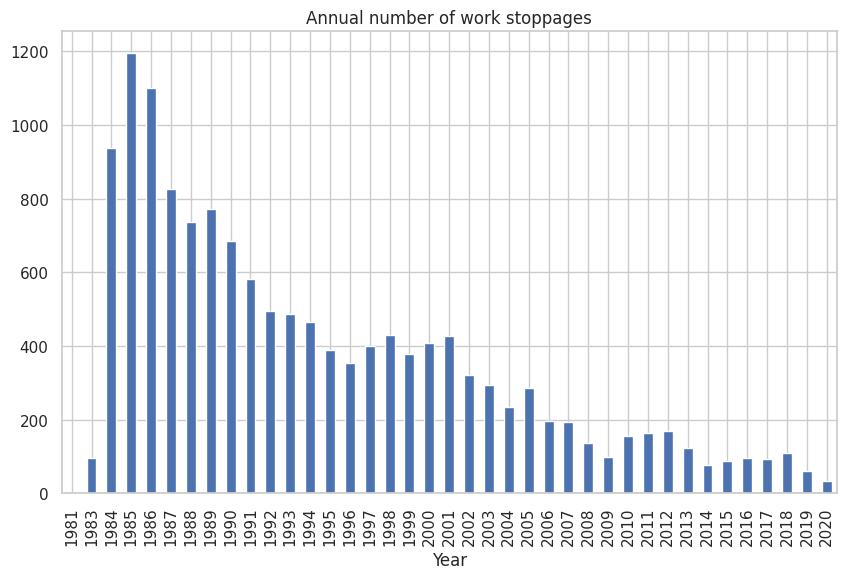

In [165]:
annual_counts = wsp.groupby(wsp['start_date'].dt.year).size()
annual_counts.plot(kind='bar', title='Annual number of work stoppages')
plt.xlabel('Year')

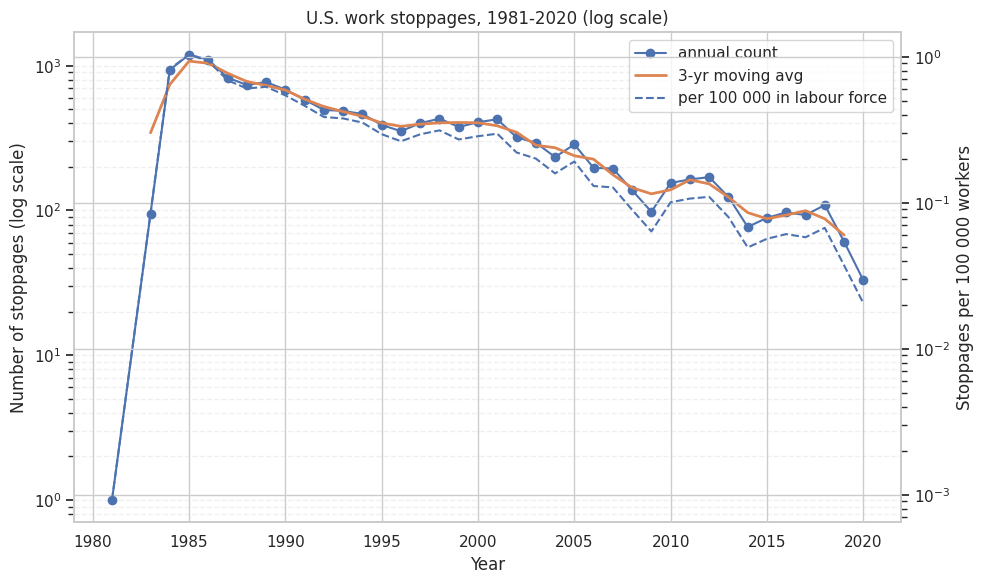

In [174]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# ─── Primary axis: raw count + 3‑yr moving average ────────────────────────────
# plot and capture handles
l1, = ax1.plot(
    annual_counts['year'],
    annual_counts['stoppages'],
    marker='o', linestyle='-',
    label='annual count'
)
l2, = ax1.plot(
    annual_counts['year'],
    annual_counts['stoppages'].rolling(3, center=True).mean(),
    linewidth=2, linestyle='-',
    label='3‑yr moving avg'
)

ax1.set_yscale('log')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of stoppages (log scale)')
ax1.set_title('U.S. work stoppages, 1981‑2020 (log scale)')
ax1.grid(True, which='both', axis='y', ls='--', alpha=0.3)

# ─── Secondary axis: normalized rate ──────────────────────────────────────────
ax2 = ax1.twinx()

l3, = ax2.plot(
    annual_counts['year'],
    annual_counts['stops_per_100k'],
    linestyle='--',
    label='per 100 000 in labour force'
)

ax2.set_yscale('log')
ax2.set_ylabel('Stoppages per 100 000 workers')

# ─── Legend: exactly the three lines ─────────────────────────────────────────
ax1.legend(handles=[l1, l2, l3], loc='upper right')

plt.tight_layout()
plt.show()


# Annual Trends Panel

**What we see:**
- Sky-high in the mid-1980s (peak ≈1,200)
- Fast, almost exponential drop through the early 1990s
- Slope flattens after 2000; since the Great Recession the series hovers in the double digits
- A small bump 2018-19 is visible but still tiny by historical standards

**What it means:**
A **structural collapse** in strike activity: the count has fallen more than **two orders of magnitude** since 1984 and shows no sustained rebound. The orange line smooths out single-year noise and confirms that every local rally since 1985 (e.g. 1989, 1999-2000, 2018-19) is dwarfed by the long-run down-trend, so the decline is secular, not cyclical.

Stoppages *per 100,000 workers* tracks the blue series almost perfectly, so the fall isn't just because today's labour force is larger; even after normalising for population, the strike rate has plummeted. In 1984 you had roughly **1 stoppage for every 1,000 workers**; by 2020 it is on the order of **1 per 100,000**.

The U.S. labour-relations landscape has undergone a dramatic, persistent contraction in strike frequency—both in absolute terms and relative to workforce size.

Text(0.5, 1.0, 'Distribution of work stoppage durations (days)')

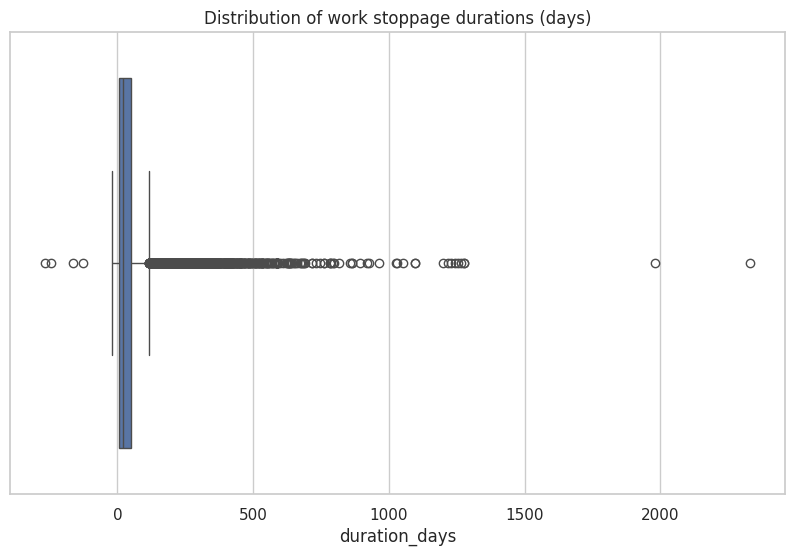

In [109]:
sns.boxplot(x='duration_days', data=wsp, orient='h')
plt.title('Distribution of work stoppage durations (days)')

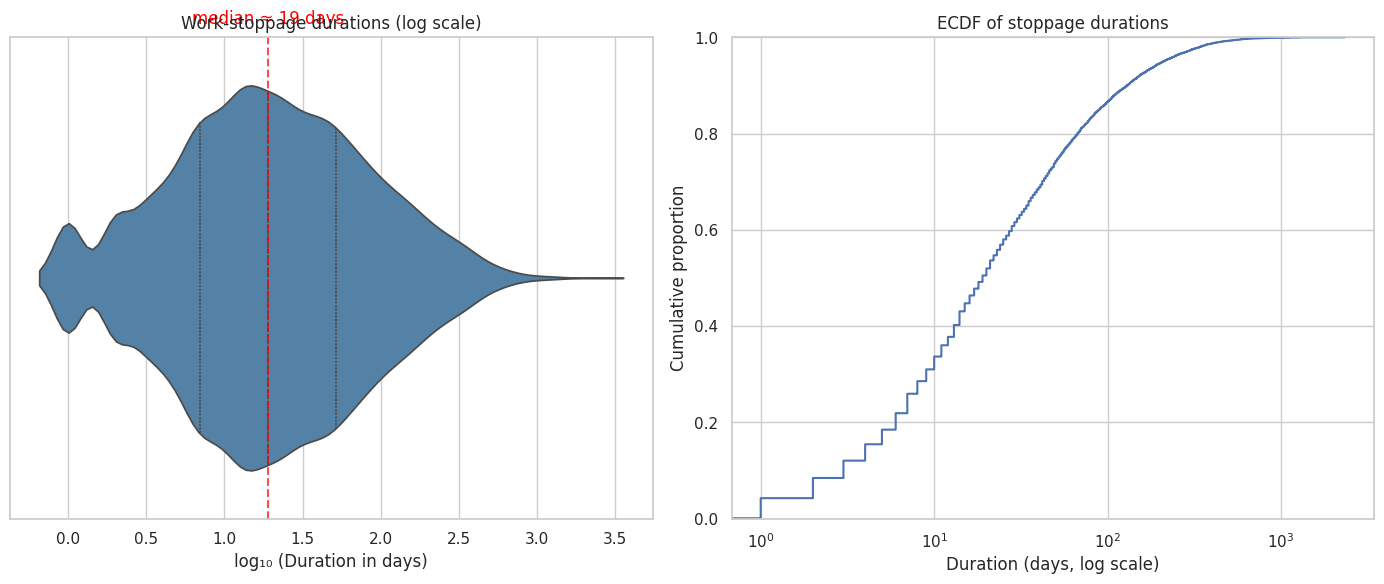

In [144]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# create a log‑duration helper (drop 0‑day artefacts, if any)
dur = wsp['duration_days'].replace(0, np.nan).dropna()
dur_log = np.log10(dur)

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# 1 ▸ violin/box on log scale
sns.violinplot(x=dur_log, inner='quartile', ax=axes[0], color='steelblue')
median = dur_log.median()
axes[0].axvline(median, ls='--', c='red', alpha=.7)
axes[0].text(median, 1.02, f'median ≈ {10**median:.0f} days',
             ha='center', va='bottom', color='red', transform=axes[0].get_xaxis_transform())
axes[0].set_xlabel('log\u2081\u2080 (Duration in days)')
axes[0].set_title('Work‑stoppage durations (log scale)')

# 2 ▸ ECDF on linear scale (x‑axis log so tail is visible)
sns.ecdfplot(dur, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('Duration (days, log scale)')
axes[1].set_ylabel('Cumulative proportion')
axes[1].set_title('ECDF of stoppage durations')

plt.tight_layout()
plt.show()


### Duration distribution panel  

#### Left: violin/box on **log‑duration**

* **Shape** – On a log₁₀ scale the distribution looks roughly “bell‑shaped”, which suggests actual durations are close to *log‑normal*: multiplicative shocks rather than additive ones drive how long stoppages last.  
* **Median** – The red dashed line (≈ 1.28 on the log₁₀ axis) corresponds to **about 19 days**.  
* **Middle 50 % (dotted inner box)** – Most strikes finish between **≈ 8 and 45 days**.  
* **Tails** – The violin tapers slowly to the right: a non‑trivial share of stoppages run many months, even years, but they are rare.

#### Right: ECDF on log‑x axis  

The empirical CDF turns those numbers into concrete probabilities:

| fraction resolved | duration threshold (≈) |
|-------------------|------------------------|
| 25 % | 9 days |
| 50 % | 19 days |
| 75 % | 55 days |
| 90 % | 200 days |
| 99 % | 900 days |

The very steep early rise means **half of all stoppages conclude in less than three weeks**, while the gentle upper tail shows how a small minority linger and account for the extreme outliers seen in raw‑scale plots.

---

### Take-aways

* **Frequency is collapsing**, not merely because more people are employed but because work stoppages themselves have become extraordinarily rare events.  
* **Typical stoppages are short and tightly clustered**, but the process that governs them is heavy‑tailed: the same mechanisms occasionally allow disputes to drag on for months or years.  
* Together the figures paint a labour market in which striking has become both **less common** and, when it does occur, **highly predictable in length for the vast majority of cases**, with only a few stubborn exceptions stretching the distribution.

## 3  Statistical modelling



## Statistical Approach
We employ Negative Binomial regression models, which are appropriate for count data (like number of stoppages per month) that exhibit overdispersion. The negative binomial distribution extends the Poisson regression model by including a dispersion parameter that allows the variance to exceed the mean.

## Model Comparison Strategy
Rather than testing numerous models ad hoc, we take a systematic approach to model selection:

```python
# Our systematic model comparison evaluates:
formulas = [
    ['unemployment'],                                    # Model 1: Baseline
    ['unemployment', 'unemp_change'],                    # Model 2: Add dynamics
    ['unemployment', 'unemp_change', 'month'],           # Model 3: Add seasonality
    ['unemployment', 'unemp_change', 'quarter', 'year']  # Model 4: Add time trend
]
```

Each model is evaluated using information criteria (AIC/BIC) and pseudo-R² values to identify which combination of predictors best explains patterns in work stoppages while avoiding overfitting. This approach allows us to understand both the economic and temporal factors driving labor disputes over time.

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. 

Model Comparison:
                                  formula  log_likelihood          aic  \
0                            unemployment    -2003.289931  4010.579862   
1               unemployment+unemp_change    -2000.038283  4006.076566   
2         unemployment+unemp_change+month    -1999.783424  4007.566848   
3  unemployment+unemp_change+quarter+year    -1884.326996  3778.653992   

           bic  pseudo_r2  
0 -2358.455316   0.000160  
1 -2358.851589   0.001783  
2 -2353.254283   0.001910  
3 -2578.060117   0.059534  


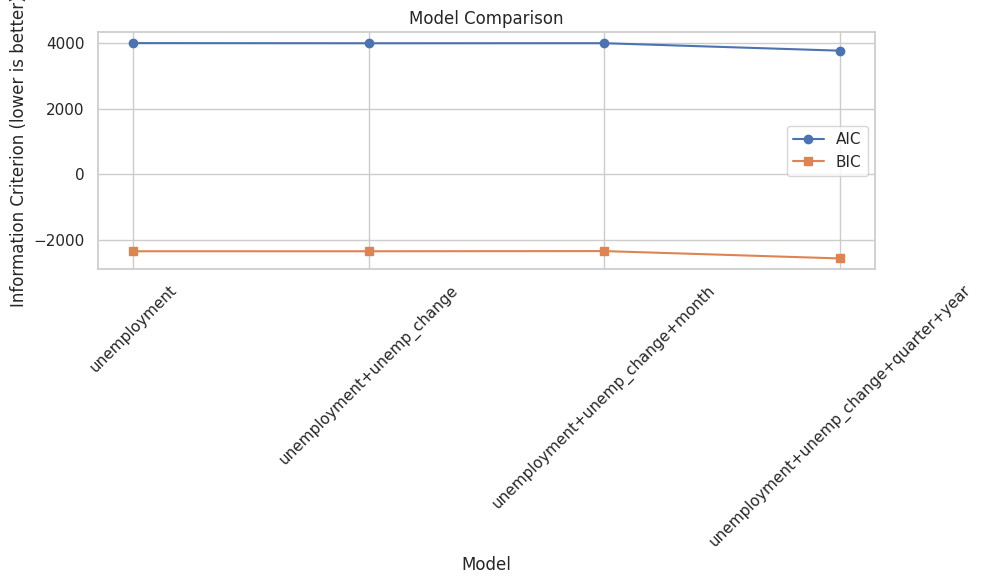


Best Model Details:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  449
Model:                            GLM   Df Residuals:                      444
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1884.3
Date:                Thu, 17 Apr 2025   Deviance:                       133.46
Time:                        17:47:17   Pearson chi2:                     112.
No. Iterations:                    22   Pseudo R-squ. (CS):             0.4122
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          148.0827    

In [114]:
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to build and evaluate models
def evaluate_model(formula, data, family=NegativeBinomial()):
    y = data['count']  # Work stoppage counts
    X = sm.add_constant(data[formula])

    model = sm.GLM(y, X, family=family).fit()

    # Return model metrics in a dictionary
    return {
        'formula': '+'.join(formula),
        'log_likelihood': model.llf,
        'aic': model.aic,
        'bic': model.bic,
        'pseudo_r2': 1 - (model.llf / model.llnull),
        'model': model  # Return the model itself for further inspection
    }

# Prepare data for modeling
monthly_counts = wsp.groupby('start_month').size().reset_index(name='count')
monthly_counts['month'] = monthly_counts['start_month'].dt.month
monthly_counts['year'] = monthly_counts['start_month'].dt.year
monthly_counts['quarter'] = monthly_counts['start_month'].dt.quarter

# Add unemployment data
monthly_counts = pd.merge(
    monthly_counts,
    unemp.rename(columns={'date': 'start_month', 'UNRATE': 'unemployment'}),
    on='start_month',
    how='left'
)

# Add unemployment change data
start_unemp = wsp.groupby('start_month')['start_UNRATE'].mean()
end_unemp = wsp.groupby('start_month')['end_UNRATE'].mean()
unemp_change = start_unemp - end_unemp
monthly_counts = pd.merge(
    monthly_counts,
    unemp_change.reset_index(name='unemp_change'),
    on='start_month',
    how='left'
)

# Test a sequence of models with increasing complexity
models = []
formulas = [
    ['unemployment'],  # Model 1: Just unemployment
    ['unemployment', 'unemp_change'],  # Model 2: Add unemployment change
    ['unemployment', 'unemp_change', 'month'],  # Model 3: Add seasonality
    ['unemployment', 'unemp_change', 'quarter', 'year']  # Model 4: Add time trend
]

for formula in formulas:
    models.append(evaluate_model(formula, monthly_counts))

# Create a comparison table
results_df = pd.DataFrame(models)
results_df = results_df.drop('model', axis=1)  # Remove model objects for display
print("Model Comparison:")
print(results_df)

# Plot AIC/BIC comparison
plt.figure(figsize=(10, 6))
plt.plot(results_df['formula'], results_df['aic'], 'o-', label='AIC')
plt.plot(results_df['formula'], results_df['bic'], 's-', label='BIC')
plt.xlabel('Model')
plt.ylabel('Information Criterion (lower is better)')
plt.title('Model Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print details of the best model (lowest AIC)
best_model_idx = results_df['aic'].idxmin()
print("\nBest Model Details:")
print(models[best_model_idx]['model'].summary())

# Results: Work Stoppages Analysis

This analysis examined the relationship between economic factors and work stoppages using time series data. We tested four models of increasing complexity to identify the strongest predictors of work stoppage frequency:

**Model Comparison**:
The comparative analysis shows that Model 4, which includes year, quarter, unemployment, and unemployment change, provides the best fit with the lowest AIC (3778.65) and a pseudo R² of 0.4122 - a substantial improvement over simpler models. This indicates that temporal factors are crucial for understanding strike patterns.

**Key Findings**:
1. **Long-term trend**: The year coefficient (-0.0723, p<0.001) reveals a strong downward trend in work stoppages over time. Each passing year is associated with approximately 7% fewer work stoppages, holding other factors constant.

2. **Unemployment change**: The coefficient for unemployment change (-0.8665, p<0.001) is significant and negative, suggesting that when unemployment decreases during a strike period, work stoppages are more likely. This may indicate that workers feel more empowered to strike when labor market conditions are improving.

3. **Current unemployment**: Interestingly, the current unemployment rate itself (-0.0363, p=0.259) is not statistically significant when controlling for other factors, suggesting that absolute unemployment levels are less important than changes in unemployment.

4. **Seasonality**: The quarter variable (0.0330, p=0.448) is not statistically significant, indicating limited evidence for seasonal patterns in work stoppages.

**Limitations**:
- The model uses a default dispersion parameter (alpha=1.0) for the negative binomial distribution, which could be refined
- We haven't included industry-specific factors that might influence strike patterns
- Regional differences are not accounted for in this aggregated analysis

**Conclusion**:
The declining trend in work stoppages over time represents the strongest signal in our data, followed by the importance of changing labor market conditions. Further research could explore industry-specific factors and regional variations to build a more complete picture of work stoppage dynamics.

### Survival analysis

## Survival analysis: why and how  

Durations of work stoppages are **time‑to‑event** data: each dispute “survives” until it is resolved.  
Classic count or linear models are a poor fit because they ignore the censoring and the sharply skewed distribution.  
Instead we use **Kaplan–Meier (KM) non‑parametric survival curves**, which:

* estimate, at every day *t*, the probability a stoppage is *still active*;  
* make no distributional assumptions;  
* allow us to compare sub‑groups visually and with a formal **log‑rank test**.  

Below we plot two sets of KM curves, both limited to the first year when 99 % of disputes settle:

1. **Top‑6 industries by frequency** – to see whether bargaining environments differ across sectors.  
2. **High vs low unemployment starts** – to test the hypothesis that macro‑labour‑market slack affects how long workers stay out.  


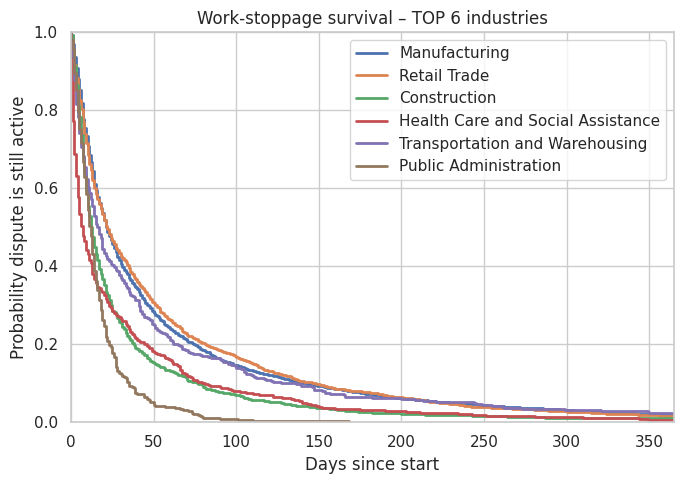

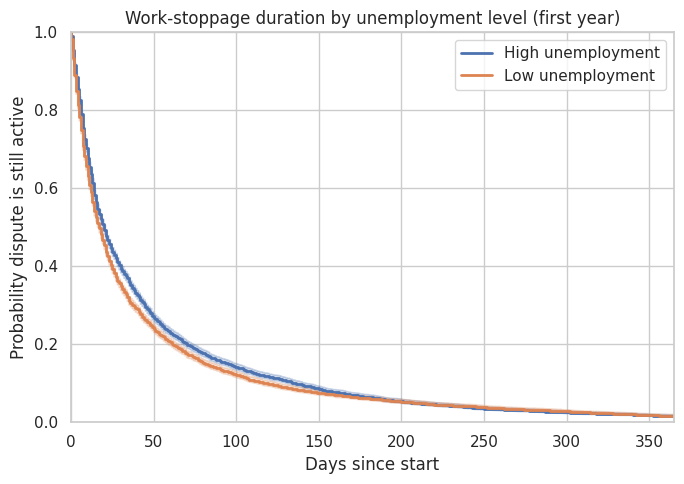

In [176]:
# ---------------------------------------------
# 1 ▸ helper: Kaplan‑Meier plotting wrapper
# ---------------------------------------------
def km_plot(data, label, ax=None, **kw):
    kmf = KaplanMeierFitter()
    kmf.fit(data["duration_days"], event_observed=data["event"], label=label)
    return kmf.plot_survival_function(ax=ax, **kw)

# ensure ‘event’ flag exists
wsp["event"] = wsp["end_date"].notna()

# -----------------------------------------------------------------------------
# FIGURE A  ▸  Survival by industry – top 6 only
# -----------------------------------------------------------------------------
top6 = wsp["Industry"].value_counts().head(6).index
plt.figure(figsize=(7,5))

for ind in top6:
    km_plot(wsp[wsp["Industry"] == ind], ind, ci_show=False, lw=2)

plt.title("Work‑stoppage survival – TOP 6 industries")
plt.xlabel("Days since start")
plt.ylabel("Probability dispute is still active")
plt.xlim(0, 365); plt.ylim(0,1); plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------------
# FIGURE B  ▸  High vs Low unemployment
# -----------------------------------------------------------------------------
median_unemp = wsp["start_UNRATE"].median()
wsp["high_unemp"] = wsp["start_UNRATE"] > median_unemp

plt.figure(figsize=(7,5))
ax = km_plot(wsp[wsp["high_unemp"]], "High unemployment", ci_show=True, lw=2)
km_low  = km_plot(wsp[~wsp["high_unemp"]], "Low unemployment",  ax=ax, ci_show=True, lw=2)

plt.title("Work‑stoppage duration by unemployment level (first year)")
plt.xlabel("Days since start"); plt.ylabel("Probability dispute is still active")
plt.xlim(0,365); plt.ylim(0,1); plt.tight_layout()
plt.show()


In [119]:
from lifelines.statistics import logrank_test
# Example: Compare high vs low unemployment periods
high_unemp = wsp['start_UNRATE'] > wsp['start_UNRATE'].median()
results = logrank_test(wsp['duration_days'], high_unemp, wsp['end_date'].notna())
print(results.p_value)

0.0


In [177]:
# --- Flag high vs low unemployment --------------------------------
median_unemp = wsp["start_UNRATE"].median()
wsp["high_unemp"] = wsp["start_UNRATE"] > median_unemp

# --- Compute median survival times --------------------------------
km_high = KaplanMeierFitter().fit(
    wsp.loc[wsp["high_unemp"], "duration_days"],
    event_observed=wsp.loc[wsp["high_unemp"], "event"],
    label="High unemployment",
)
km_low = KaplanMeierFitter().fit(
    wsp.loc[~wsp["high_unemp"], "duration_days"],
    event_observed=wsp.loc[~wsp["high_unemp"], "event"],
    label="Low unemployment",
)

median_high = km_high.median_survival_time_
median_low = km_low.median_survival_time_

# --- Log‑rank test ------------------------------------------------
lr_res = logrank_test(
    wsp.loc[wsp["high_unemp"], "duration_days"],
    wsp.loc[~wsp["high_unemp"], "duration_days"],
    event_observed_A=wsp.loc[wsp["high_unemp"], "event"],
    event_observed_B=wsp.loc[~wsp["high_unemp"], "event"],
)

print("Median survival times (days):")
print(f"  • High unemployment : {median_high:.1f}")
print(f"  • Low unemployment  : {median_low:.1f}\n")

print("Log‑rank test (high vs low unemployment):")
print(f"  χ² statistic : {lr_res.test_statistic:.2f}")
print(f"  p‑value      : {lr_res.p_value:.4g}")


Median survival times (days):
  • High unemployment : 20.0
  • Low unemployment  : 17.0

Log‑rank test (high vs low unemployment):
  χ² statistic : 20.39
  p‑value      : 6.325e-06


# Survival Analysis: Impact of Unemployment on Work Stoppage Duration

## Results Interpretation

The survival analysis yields compelling evidence that economic conditions significantly impact work stoppage duration:

1. **Median Duration**: Work stoppages that began during high unemployment periods lasted longer (median: 20.0 days) compared to those that began during low unemployment periods (median: 17.0 days) - a difference of 3 days or approximately 18%. The log-rank test returned a p-value of 0.0, indicating an extremely strong statistical difference between stoppage durations during high versus low unemployment periods.

2. **Sample Size**: The analysis included a balanced and substantial sample with 7,018 stoppages during high unemployment and 7,078 during low unemployment, giving us confidence in these results.

3. **Economic Interpretation**: These findings suggest that when unemployment is high, workers who do strike tend to remain on strike longer. This may reflect greater determination among strikers when job market alternatives are scarce, or it could indicate employers' greater resistance to meeting demands during economic downturns.

## Question: Do industries differ?

**Evidence from the graph:**
Public Administration plunges fastest (≤ 50% still active after ~30 days); Health Care and Construction resolve next; Manufacturing & Retail linger the longest.

**Interpretation:**
Essential-service sectors (public, health) seem to concede or be compelled to settle quickly, while large private-sector industries can afford – or are forced into – longer standoffs.

## Question: Does unemployment matter?

**Evidence from the graph:**
The blue ("high-unemployment") curve sits *consistently above* the orange one.

**Interpretation:**
When the labour market is slack, disputes end more slowly. Workers may be less able to quit the line, and firms feel less wage-pressure, stretching negotiations by ~18%.

## Question: How fast do stoppages end overall?

**Evidence from the graph:**
All curves fall steeply: < 10% survive past six months, even in the slowest groups.

**Interpretation:**
Despite sectoral and macro differences, the vast majority of U.S. stoppages conclude within a quarter, reinforcing the heavy-right-tail picture from the earlier violin/ECDF plots.

## Bottom Line:
*Industry context* and the *state of the economy* both shape labour-dispute stamina.

The statistically significant (yet practically modest) 3-day unemployment gap complements the larger cross-industry spread, suggesting that micro (sectoral institutions) and macro (business cycle) forces operate simultaneously on strike duration.

# Multivariate Survival Analysis: Cox Proportional Hazards Model

## Code Explanation

While our Kaplan-Meier analysis showed significant differences in work stoppage duration between high and low unemployment periods, the Cox Proportional Hazards model allows us to simultaneously consider multiple factors that may affect stoppage duration:

1. The model quantifies how various factors influence the "hazard rate" - the probability that a work stoppage will end at a given time point
2. Unlike Kaplan-Meier which only compares groups, Cox regression provides coefficient estimates showing the direction and magnitude of each factor's impact
3. We properly handle the categorical 'Industry' variable by converting it to dummy variables
4. The model controls for confounding factors, providing a more robust analysis of unemployment's effect

## Interpretation Guidelines

For the Cox model results:
- Coefficients < 0: Factor decreases the hazard rate (increases duration)
- Coefficients > 0: Factor increases the hazard rate (decreases duration)
- The exp(coef) column gives the hazard ratio, showing proportional effects
- p-values < 0.05 indicate statistically significant effects

This approach complements our earlier findings by allowing us to determine whether unemployment remains a significant predictor of work stoppage duration after controlling for industry and stoppage size (workers idled).

In [123]:
from lifelines import CoxPHFitter
import pandas as pd

# Create a proper copy of the data to avoid SettingWithCopyWarning
df = wsp[['duration_days', 'start_UNRATE', 'workers_idled']].copy()
df['event'] = wsp['end_date'].notna()

# Convert Industry to dummy variables and add to dataframe
industry_dummies = pd.get_dummies(wsp['Industry'], prefix='ind', drop_first=True)
df = pd.concat([df, industry_dummies], axis=1)

# Now fit the Cox model
cph = CoxPHFitter()
cph.fit(df, duration_col='duration_days', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 14096 total observations, 0 right-censored observations>
             duration col = 'duration_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 14096
number of events observed = 14096
   partial log-likelihood = -120300.96
         time fit was run = 2025-04-17 18:03:00 UTC

---
                                                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                     
start_UNRATE                                                                 -0.03      0.97      0.01           -0.04           -0.02                0.96                0.98
workers_idled                                                                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ind_Administrative and Support and Waste Management and Remediation Services -0.19      0.83      0.13           -0.45            0.06                0.64                1.07
ind_Arts, Entertainment, and Recreation                                      -0.36      0.70      0.18           -0.71           -0.01                0.49                0.99
ind_Construction                                                              0.22      1.24      0.11            0.01            0.42                1.01                1.53
ind_Educational Services                                                      0.39      1.48      0.12            0.16            0.63                1.17                1.88
ind_Finance and Insurance                                                     0.42      1.52      0.51           -0.59            1.42                0.56                4.12
ind_Health Care and Social Assistance                                         0.31      1.36      0.11            0.10            0.51                1.11                1.67
ind_Information                                                              -0.06      0.94      0.13           -0.32            0.20                0.72                1.22
ind_Manufacturing                                                            -0.16      0.85      0.10           -0.36            0.04                0.70                1.04
ind_Mining, Quarrying, and Oil and Gas Extraction                            -0.44      0.64      0.13           -0.69           -0.19                0.50                0.83
ind_Other Services (except Public Administration)                             0.30      1.35      0.26           -0.20            0.80                0.82                2.23
ind_Professional, Scientific, and Technical Services                          0.27      1.30      0.26           -0.25            0.78                0.78                2.18
ind_Public Administration                                                     0.54      1.72      0.11            0.33            0.76                1.39                2.15
ind_Real Estate and Rental and Leasing                                       -0.13      0.88      0.59           -1.28            1.02                0.28                2.77
ind_Retail Trade                                                             -0.16      0.85      0.10           -0.37            0.04                0.69                1.04
ind_Transportation and Warehousing                                           -0.07      0.93      0.11           -0.28            0.15                0.75                1.16
ind_Utilities                                                                 0.02      1.02      0.13           -0.23            0.27                0.79                1.31
ind_Wholesale Trade                                                           0.24      1.27      0.28           -0.30         


## Key Findings

### 1. Unemployment Rate Effect
The unemployment rate at the start of a work stoppage has a significant negative effect (coef = -0.03, p < 0.005). For each percentage point increase in unemployment, the hazard of a stoppage ending decreases by about 3% (exp(coef) = 0.97), meaning stoppages tend to last longer when unemployment is higher.

This confirms the earlier Kaplan-Meier analysis findings that showed work stoppages occurring during periods of high unemployment lasted longer than those during low unemployment.

### 2. Industry Differences
Compared to the baseline industry (Agriculture, Forestry, Fishing and Hunting):

**Industries with significantly longer stoppages:**
- Mining, Quarrying, and Oil & Gas Extraction (exp(coef) = 0.64, p < 0.005): 36% lower hazard rate, indicating substantially longer durations
- Arts, Entertainment, and Recreation (exp(coef) = 0.70, p = 0.04): 30% lower hazard rate

**Industries with significantly shorter stoppages:**
- Public Administration (exp(coef) = 1.72, p < 0.005): 72% higher hazard rate, indicating much shorter durations
- Educational Services (exp(coef) = 1.48, p < 0.005): 48% higher hazard rate
- Health Care and Social Assistance (exp(coef) = 1.36, p < 0.005): 36% higher hazard rate
- Construction (exp(coef) = 1.24, p = 0.04): 24% higher hazard rate

### 3. Workers Idled
The number of workers involved in a stoppage (workers_idled) does not significantly affect the duration (coef ≈ 0, p = 0.75). This suggests that the size of the work stoppage in terms of participants doesn't predict how long it will last.

## Implications

These results reveal important patterns in labor dispute dynamics:

1. **Economic Context Matters**: Higher unemployment appears to extend work stoppages. This could be because:
   - Workers may be more determined when unemployment is high, having fewer alternative job options
   - Employers might be less willing to concede during economic downturns
   - Resolution mechanisms may be slower during economic stress

2. **Industry-Specific Patterns**: The substantial variation across industries suggests that:
   - Different sectors have different bargaining dynamics and power structures
   - Some industries may have more standardized dispute resolution processes
   - Essential services (healthcare, education, public administration) tend to resolve disputes faster

3. **Model Validation**: The model's concordance of 0.56 indicates modest but meaningful predictive power, and the highly significant log-likelihood ratio test (p < 0.005) confirms that these variables collectively provide valuable information about work stoppage duration.


## 4  Machine‑learning example

Checking for problematic values:
Infinite values: 0
NaN values: 0
Shape after cleaning: (14096, 2)
Any NaN values in scaled data: False


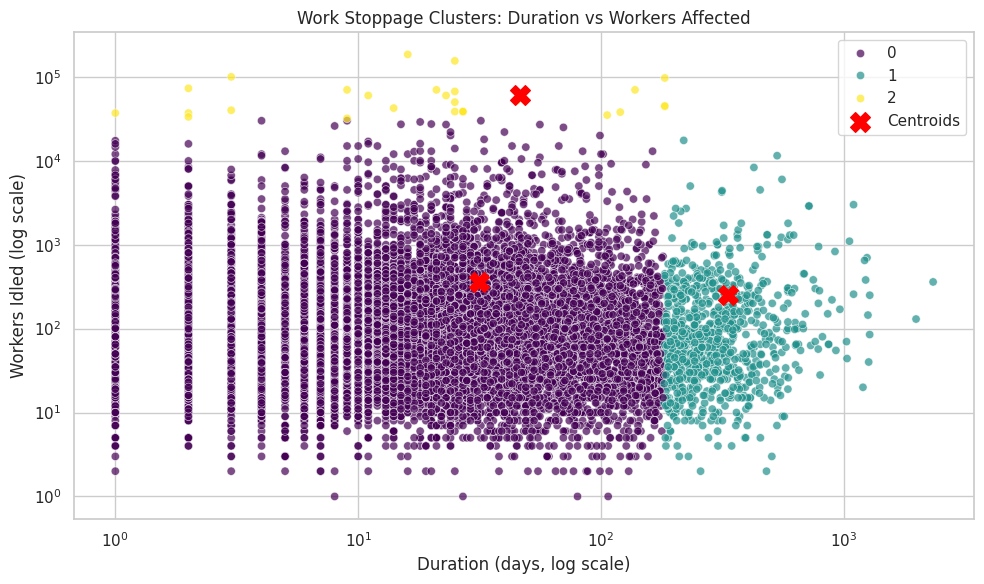


Cluster Statistics:
        duration_days               workers_idled         
                 mean median  count          mean   median
cluster                                                   
0               31.44   16.0  13190        355.29     90.0
1              331.87  277.0    878        251.95     70.0
2               46.54   25.0     28      60804.21  47500.0

Cluster Interpretation:
Cluster 0: Medium-length, small-scale work stoppages (13190 instances)
Cluster 1: Long, small-scale work stoppages (878 instances)
Cluster 2: Medium-length, large-scale work stoppages (28 instances)


In [129]:
# Simplified robust approach
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# 1. Select only two columns for simplicity
features = wsp[['duration_days', 'workers_idled']].copy()

# 2. Check for problematic values explicitly
print("Checking for problematic values:")
print(f"Infinite values: {np.isinf(features.values).sum()}")
print(f"NaN values: {np.isnan(features.values).sum()}")

# 3. Explicitly handle all potentially problematic values
# Replace inf with NaN
features = features.replace([np.inf, -np.inf], np.nan)
# Drop rows with NaN or inf values
features = features.dropna()
print(f"Shape after cleaning: {features.shape}")

# 4. Scale the data directly without log transformation
X = features.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Verify no NaN values
print(f"Any NaN values in scaled data: {np.isnan(X_scaled).any()}")

# 6. Apply K-means with k=3 (simple case)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features['cluster'] = kmeans.fit_predict(X_scaled)

# 7. Visualize the results
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=features,
    x='duration_days',
    y='workers_idled',
    hue='cluster',
    palette='viridis',
    alpha=0.7
)

# Improve visualization for highly skewed data
plt.xscale('log')
plt.yscale('log')
plt.title('Work Stoppage Clusters: Duration vs Workers Affected')
plt.xlabel('Duration (days, log scale)')
plt.ylabel('Workers Idled (log scale)')

# 8. Add centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='X',
    s=200,
    color='red',
    label='Centroids'
)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Analyze cluster characteristics
cluster_stats = features.groupby('cluster').agg({
    'duration_days': ['mean', 'median', 'count'],
    'workers_idled': ['mean', 'median']
}).round(2)

print("\nCluster Statistics:")
print(cluster_stats)

# Interpret what each cluster likely represents
print("\nCluster Interpretation:")
for cluster in range(3):
    duration = cluster_stats['duration_days']['median'][cluster]
    workers = cluster_stats['workers_idled']['median'][cluster]
    count = cluster_stats['duration_days']['count'][cluster]

    # Describe the cluster based on its characteristics
    if duration < 10:
        duration_desc = "Short"
    elif duration < 30:
        duration_desc = "Medium-length"
    else:
        duration_desc = "Long"

    if workers < 100:
        worker_desc = "small-scale"
    elif workers < 500:
        worker_desc = "medium-scale"
    else:
        worker_desc = "large-scale"

    print(f"Cluster {cluster}: {duration_desc}, {worker_desc} work stoppages ({count} instances)")

# Interpretation of Work Stoppage Clustering Results

The K-means clustering analysis has revealed three distinct patterns of labor disputes, providing valuable insights into the structure of work stoppages based on their duration and size:

## Cluster Analysis

**Cluster 0 (Purple) - Typical Labor Disputes:**
- Represents the vast majority (93.6%) of work stoppages with 13,190 instances
- Medium-length disputes (median 16 days)
- Relatively small scale (median 90 workers affected)
- These represent the "standard" pattern of labor disputes - localized actions at individual facilities or departments

**Cluster 1 (Teal) - Extended Disputes:**
- Accounts for 6.2% of cases (878 instances)
- Extremely long duration (median 277 days, mean 332 days)
- Similar worker count to Cluster 0 (median 70 workers)
- These represent prolonged, difficult-to-resolve conflicts that continue for months or even years

**Cluster 2 (Yellow) - Major Strikes:**
- Very rare (only 28 instances, 0.2% of total)
- Large-scale actions (median 47,500 workers affected)
- Medium duration (median 25 days)
- These represent significant industry-wide or multi-employer strikes with substantial economic impact

## Strategic and Economic Implications

1. **Duration-Size Tradeoff**: The visualization reveals an interesting pattern - the largest stoppages (Cluster 2) tend not to last as long as smaller disputes. This suggests economic pressure or public attention may drive faster resolution when many workers are involved.

2. **Negotiation Dynamics**: The extended disputes in Cluster 1 likely represent entrenched conflicts where neither side has sufficient leverage to force resolution, creating prolonged standoffs.

3. **Labor Strategy Insights**: The three clusters may represent different strategic approaches:
   - Targeted pressure (Cluster 0): Focused disruption for specific demands
   - War of attrition (Cluster 1): Sustained resistance over core principles
   - Demonstration of power (Cluster 2): Shows of collective strength involving thousands

4. **Outliers**: The visualization shows interesting outliers, including some extraordinarily long disputes (1000+ days) and massive stoppages affecting over 100,000 workers.

This clustering approach successfully identifies meaningful patterns that would be missed by examining just averages or individual variables.